# Scoring the quality of synthetic datasets

<head>
  <meta name="title" content="Scoring the quality of synthetic datasets with data-centric AI"/>
  <meta property="og:title" content="Scoring the quality of synthetic datasets with data-centric AI"/>
  <meta name="twitter:title" content="Scoring the quality of synthetic datasets with data-centric AI"/>
  <meta name="image" content="/img/syntheticdata.png" />
  <meta property="og:image" content="/img/syntheticdata.png" />
  <meta name="description" content="How to automatically detect unrealistic synthetic examples and underrepresented real data scenarios."  />
  <meta property="og:description" content="How to automatically detect unrealistic synthetic examples and underrepresented real data scenarios." />
  <meta name="twitter:description" content="How to automatically detect unrealistic synthetic examples and underrepresented real data scenarios." />
</head>

This tutorial demonstrates how to quantify the quality of a synthetic dataset by contrasting it against real data along different dimensions. When you provide an appropriately formatted dataset that has both real and synthetic examples, Cleanlab Studio can analyze the quality of your synthetic data for various shortcomings. You can use this synthetic dataset evaluation to quantitatively compare different synthetic data generators (including prompts being used to produce each synthetic dataset). While most Cleanlab Studio functionality scores the quality of each example in a dataset, this tutorial evaluates the **overall quality of the entire synthetic dataset**.

After quantifying this overall quality, you can the inspect the individual synthetic samples that are most responsible for detected shortcomings. These can include: synthetic samples that appear unrealistic, synthetic samples that are too similar to one another, synthetic samples that are basically memorized copies of real data, as well as real data scenarios that are under-represented amongst the synthetic samples.

![Visualizing shortcomings of a synthetic dataset compared to a real dataset](./assets/synthetic-dataset-tutorial/synthetic_thumbnail.png)


## Install and import dependencies

Make sure you have `wget` and `zip` installed to run this tutorial. You can use pip to install all other packages required for this tutorial as follows:

In [ ]:
%pip install datasets Pillow cleanlab-studio

In [1]:
from cleanlab_studio import Studio
from cleanlab_studio.utils.synthetic import score_synthetic_dataset
from datasets import load_dataset
from typing import Dict

import os
import datasets
import pandas as pd
import pathlib

**Optional: Initialize helper functions to render images in DataFrames and convert dataset to dataframes**



In [2]:

from IPython.core.display import HTML
from PIL import Image
from io import BytesIO
from base64 import b64encode

IMAGE_DIR = "images"

def path_to_img_html(path: str) -> str:
    """
    Converts an image file path to HTML image tag with base64 encoded image data.
    
    Parameters
    ----------
    path: str 
        The path of the image file.

    Returns
    -------
    str: The HTML image tag with base64 encoded image data.
    """
    buf = BytesIO()
    with Image.open(f"{IMAGE_DIR}/{path}") as image:
        image.save(buf, format="JPEG")
    b64 = b64encode(buf.getvalue()).decode("utf8")
    return f'<img src="data:image/jpeg;base64,{b64}" width="100" alt="" />'

def display(df: pd.DataFrame) -> None:
    return HTML(df.to_html(escape=False, formatters=dict(image=path_to_img_html)))

def dataset_to_dataframe(
    dataset: datasets.Dataset,
    label_column: str,
    image_column: str,
    synthetic_flag: str,
) -> pd.DataFrame:

    # Convert to pandas dataframe
    df = dataset.to_pandas()

    # Create id column
    ids = [f"{synthetic_flag}_{i}" for i in range(len(df))]
    df["id"] = ids

    # Format image column
    image_to_image_filename = lambda row: str(pathlib.Path(row[image_column]["path"]).relative_to(f"{pwd}/{IMAGE_DIR}"))
    df["image"] = df.apply(image_to_image_filename, axis=1)

    # Format label column
    int2str = dataset.features[label_column].int2str
    df["label"] = df[label_column].apply(int2str)

    # Add synthetic flag
    df["real_or_synthetic"] = synthetic_flag

    return df[["id", "image", "label", "real_or_synthetic"]]

In [ ]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Datasets/synthetic-quality/real_images.zip'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Datasets/synthetic-quality/synthetic_images.zip'

!unzip -qu real_images.zip -d images/ && unzip -qu synthetic_images.zip -d images/

In [ ]:
pwd = os.getcwd()

# Load dataset from local directory
real_dataset = load_dataset("imagefolder", data_dir=f"{IMAGE_DIR}/real", split="train")
synthetic_dataset = load_dataset("imagefolder", data_dir=f"{IMAGE_DIR}/synthetic", split="train")

# Convert to pandas dataframes
real_df = dataset_to_dataframe(
    real_dataset, label_column="label", image_column="image", synthetic_flag="real"
)
synthetic_df = dataset_to_dataframe(
    synthetic_dataset, label_column="label", image_column="image", synthetic_flag="synthetic"
)

# Combine real and synthetic dataframes
combined_dataset_df = pd.concat([real_df, synthetic_df], ignore_index=True)

,id,image,label,real_or_synthetic
44,real_44,,pineapple,real
290,synthetic_90,,pineapple,synthetic
146,real_146,,watermelon,real
309,synthetic_109,,watermelon,synthetic

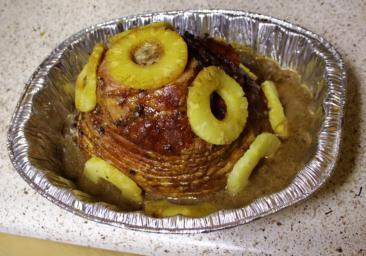
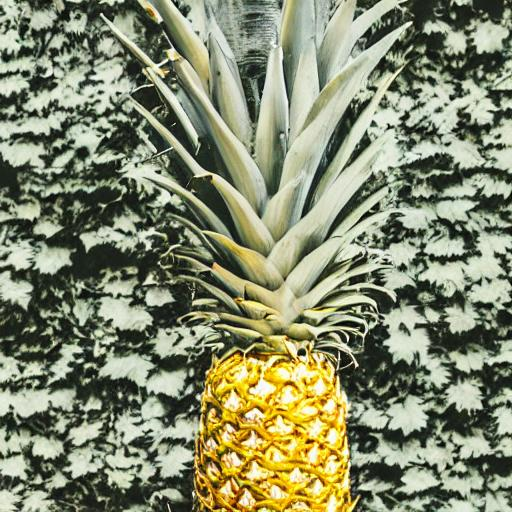
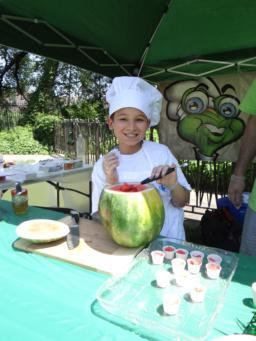
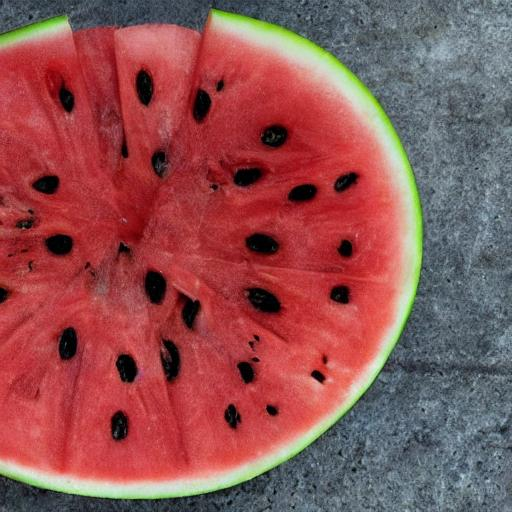

In [4]:
display(combined_dataset_df.groupby(["label", "real_or_synthetic"]).sample(1))

Note this DataFrame also contains `id` and `label` columns, which are relevant metadata that we'd like to see in our Cleanlab Studio results.  Such metadata is optional, it will not be used by Cleanlab Studio to evaluate the quality of the synthetic dataset.

## Load the combined real+synthetic dataset into Cleanlab Studio

### Dataset Structure and Formatting

Cleanlab Studio has particular directory structure requirements when uploading locally-hosted image datasets, and we are adhering to these requirements to ensure the smooth integration of our dataset. 

Here's the expected directory structure:

```
images
├── metadata.csv
├── real
│   ├── pineapple
│   │   ├── image_0.png
|   |   ├── image_1.png
│   │   ⋮
│   └── watermelon
|       ├── image_1.png
│       ├── image_0.png
│       ⋮
└── synthetic
    ├── pineapple
    │   ├── image_0.png
    │   ├── image_1.png
    │   ⋮
    └── watermelon
        ├── image_0.png
        ├── image_1.png
        ⋮
```

- **Parent Directory**: For our demonstration, `images/` serves as the top-level directory. It holds all images and the essential `metadata.csv` file.

- **Real & Synthetic Directories**: These are fundamental divisions of our dataset. The `real/` and `synthetic/` directories clearly differentiate between actual and generated images.

- **Sub-category Directories (Optional)**: Divisions such as `pineapple/` and `watermelon/` are for organizational clarity. Cleanlab Studio will not consider these in the synthetic dataset assessment we run here.

Ensure that your image dataset respects a similar structure.

We write the contents of our combined DataFrame to such a `metadata.csv` file and zip the `images/` directory for loading our data into Cleanlab Studio.

In [5]:
combined_dataset_df.to_csv(f"{IMAGE_DIR}/metadata.csv", index=False)

In [6]:
!zip -rq formatted_synthetic_data.zip images/

### Metadata.csv Contents
The `metadata.csv` plays a critical role in helping Cleanlab Studio understand and categorize each image. Below, we delve into the purpose and requirements of each column:

```
id,image,label (optional metadata),real_or_synthetic
real_0,real/pineapple/image_0.png,pineapple,real
real_1,real/pineapple/image_1.png,pineapple,real
real_2,real/pineapple/image_10.png,pineapple,real
...
synthetic_199,synthetic/watermelon/image_97.png,watermelon,synthetic
synthetic_200,synthetic/watermelon/image_98.png,watermelon,synthetic
synthetic_201,synthetic/watermelon/image_99.png,watermelon,synthetic
```

- `id`: A unique identifier for each image. It doesn't have to follow the `real_`/`synthetic_` prefix format as demonstrated above. The chosen format in this tutorial is for clarity and convenience.
- `image`: This column represents the relative path to the image file within the top-level directory of the ZIP file (note: do not include the name of the top-level directory in the path).
- `real_or_synthetic`: *This column is essential for this tutorial*. It categorizes the image as either real or synthetic. Make sure you correctly specify this for every image.
- `label` (optional metadata): This column is purely optional. It provides a label for the image but doesn't impact the evaluation. It's a piece of additional metadata attached to each example, allowing further analysis of the results if desired.

From this point, it's just a matter of uploading the zip-file to Cleanlab Studio.

If working with a large image dataset, see the [Finding Issues in Large-Scale Image Datasets tutorial](../large_image_datasets/).


In [7]:
# you can find your API key by going to studio.cleanlab.ai/upload, 
# clicking "Upload via Python API", and copying the API key there
API_KEY = "<insert your API key>"
studio = Studio(API_KEY)

dataset_id = studio.upload_dataset("formatted_synthetic_data.zip", dataset_name="SyntheticData")

## Create a Project

Using your `dataset_id` from the previous step, you can create a Project in Cleanlab Studio with one line of code! This will train Cleanlab's AI to analyze your synthetic dataset for shortcomings relative to the real data, which takes some time ( ~1-2 minutes for our tutorial dataset). You will get an email when the process has completed.


In [8]:
project_id = studio.create_project(
    dataset_id, 
    project_name="SyntheticDataProject", 
    modality="image", 
    model_type="fast", 
    label_column="real_or_synthetic", # Don't confuse this with the column named "label" in the dataset
)
print(f"Project successfully launched, Cleanlab's AI is analyzing your data! project_id: {project_id}")

You should only execute the above cell once per dataset. After launching the project, you can poll for its status to programmatically wait until the results are ready for review (you'll also get an email). You can optionally provide a `timeout` parameter after which the function will stop waiting even if the project is not ready.

**Warning!** This next cell may take a long time to execute while Cleanlab's AI model is training. If your Jupyter notebook has timed out during this process, then you can resume work by re-running this cell (which should return instantly if the Project has completed; **do not** create a new Project).

In [9]:
cleanset_id = studio.get_latest_cleanset_id(project_id)
print(f"cleanset_id: {cleanset_id}")
studio.wait_until_cleanset_ready(cleanset_id)

Once the Project is ready, fetch the Cleanlab columns that have been generated with useful metadata.

In [10]:
cleanlab_cols = studio.download_cleanlab_columns(cleanset_id)

# Combine the dataset with the cleanlab columns
cleanset_df = combined_dataset_df.merge(cleanlab_cols, on='image')

## Quantitatively evaluate the synthetic dataset

Now that we've obtained the results (`cleanlab_cols`) of our Project, let's compute numerical scores that evaluate the overall quality of our synthetic dataset. Thus far, we have not explicitly told Cleanlab Studio that our goal is synthetic dataset assessment (we just ran a typical Project with a special `real_vs_synthetic` column in our dataset). Here we will use functions intended specifically for synthetic dataset assessment.

Here's all the code needed to comprehensively evaluate the quality of a synthetic dataset.

In [11]:
score_synthetic_dataset(cleanset_df)

Number of real examples: 200
Number of synthetic examples: 202


{'unrealistic': 0.8644713165425743,
 'unrepresentative': 0.860247434498,
 'unvaried': 0.0891089108910891,
 'unoriginal': 0.024752475247524754}

The 4 returned scores quantify different shortcomings of the synthetic dataset:

- **Unrealistic**: Evaluates how distinguishable the synthetic data appears from real data. High values indicate there are many unrealistic-looking synthetic samples which look obviously fake.
- **Unrepresentative**: Measures how poorly represented the real data is amongst the synthetic data samples. High values indicate there exist tails of the real data distribution (rare scenarios) that the distribution of synthetic samples fails to capture.
- **Unvaried**: Evaluates the diversity among synthetic samples. High values indicate a non-diverse synthetic data generator that produces many similar samples which look like near duplicates of other synthetic samples.
- **Unoriginal**: Evaluates the novelty of the synthetic data. High values indicate many synthetic samples are near duplicates of an example from the real dataset, i.e. the synthetic data generator may be memorizing/overfitting the real data too closely and failing to generalize.

**Note**: For all of these scores, higher values indicate a lower-quality synthetic dataset.

**Optional: Define visualization helper functions**

We define some helper methods below for rendering a DataFrame of near-duplicate examples.


In [47]:


def get_near_duplicate_groupings(df: pd.DataFrame) -> dict:
    # Create a dictionary with the near_duplicate_cluster_id as keys and list of indices as values
    grouped = df.groupby('near_duplicate_cluster_id')
    near_duplicate_groups = {name: group.index.tolist() for name, group in grouped}

    # For each row, if it is a near duplicate, get the group indices excluding its own index
    near_duplicate_group_column = df.apply(lambda row: [idx for idx in near_duplicate_groups.get(row['near_duplicate_cluster_id'], []) if idx != row.name] if row['is_near_duplicate'] else [], axis=1)
    
    return {index: group for index, group in near_duplicate_group_column.items()}

def get_associated_images_html(index, df, groupings):
    associated_ids = groupings.get(index, [])
    associated_paths = df.loc[associated_ids, 'image'].tolist()

    img_htmls = [path_to_img_html(path) for path in associated_paths]

    # Add a caption of the id for each image
    captions = [f'<figcaption style="text-align:center">{df.loc[id]["id"]}</figcaption>' for id in associated_ids]

    # Wrap each image in a figure tag, and add a caption
    img_htmls_with_captions = [f'<figure style="width: 100px; margin:0 20px">{img_html}{caption}</figure>' for img_html, caption in zip(img_htmls, captions)]

    return '<div style="display:flex">' + ''.join(img_htmls_with_captions) + '</div>'

def display_duplicated_examples(df: pd.DataFrame, group_by="near_duplicate_cluster_id", image_column="image", display_columns=None, formatters=None):
    """Groups the dataframe by the given column and displays the first synthetic example in each group, with the associated images of the group. If no synthetic example is present, defaults to the first example."""
    # Validate columns
    display_columns, formatters, _associated_images = _set_display_arguments(df, group_by, image_column, display_columns, formatters)

    # Rearrange grouped dataframe to display the associated images
    df_copy = df.copy()
    groupings = get_near_duplicate_groupings(df_copy)
    df_copy[_associated_images] = df_copy.index.map(lambda index: get_associated_images_html(index, df_copy, groupings))

    # Modify the way the dataframe is grouped to prioritize synthetic examples
    grouped = df_copy.groupby(group_by)

    # Get the index of the first synthetic example in each group (if available)
    synthetic_idx = grouped['real_or_synthetic'].apply(lambda x: x.eq('synthetic').idxmax() if x.eq('synthetic').any() else x.index[0])

    # Select the rows corresponding to the synthetic examples or the first example in each group
    df_displayed = df_copy.loc[synthetic_idx]

    return HTML(df_displayed[display_columns].to_html(escape=False, formatters=formatters))

def display_unoriginal_synthetic_examples(df: pd.DataFrame, group_by="near_duplicate_cluster_id", image_column="image", display_columns=None, formatters=None):
    
    # Validate columns
    display_columns, formatters, _associated_images = _set_display_arguments(df, group_by, image_column, display_columns, formatters)

    # Rearrange grouped dataframe to display the associated images
    df_copy = df.copy()
    groupings = get_near_duplicate_groupings(df_copy)
    # Filter groupings to only have real examples
    groupings = {
        key: [id for id in group if df_copy.loc[id]['real_or_synthetic'] == 'real']
        for key, group in groupings.items()
    }
    
    # Filter dataframe to only keep the synthetic examples
    df_displayed = df_copy.query("real_or_synthetic == 'synthetic'").copy()
    df_displayed['associated_images'] = df_displayed.index.map(lambda index: get_associated_images_html(index, df_copy, groupings))
    return HTML(df_displayed[display_columns].to_html(escape=False, formatters=formatters))

def _set_display_arguments(df, group_by, image_column, display_columns, formatters):
    if group_by not in df.columns:
        raise ValueError(f"The given group_by column '{group_by}' not found in dataframe. Valid column names are: {df.columns.tolist()}")

    if image_column not in df.columns:
        raise ValueError(f"The given image_column '{image_column}' not found in dataframe. Valid column names are: {df.columns.tolist()}")
    
    # 2. Configuration Setup
    _associated_images = "associated_images"
    if display_columns is None:
        display_columns = ["id", image_column, "label", "real_or_synthetic", _associated_images, group_by]
    elif image_column not in display_columns:
        # Check for the image column in the provided display columns
        print(f"Warning: The given image_column '{image_column}' is not in the display_columns. Inserting it at position 1.")
        display_columns.insert(1, image_column)

    if _associated_images not in display_columns:
        display_columns.append(_associated_images)

    if formatters is None:
        formatters = {image_column: path_to_img_html}
    
    # 3. Additional Column Validations (excluding _associated_images since we're adding it ourselves)
    _invalid_columns = [column for column in display_columns if column not in df.columns and column != _associated_images]
    if _invalid_columns:
        raise ValueError(f"Invalid columns found in `display_columns`: {_invalid_columns}. Valid column names are: {df.columns.tolist()}")
    return display_columns,formatters,_associated_images


## Inspect individual synthetic samples most responsible for a low-quality dataset

**Unrealistic.**  The unrealistic score quantifies how different the synthetic images look compared to real images. A high score for the dataset indicates that the synthetic data generator makes many images that look obviously fake. Mathematically, this score is computed as 1 minus the average Cleanlab **label issue score** of all synthetic examples in a joint dataset with binary labels `real` or `synthetic`.

Let's see which synthetic samples look most unrealistic in our dataset. To do so, sort the synthetic samples by their label issue scores (in ascending order). This produces a ranking of the synthetic data in terms of how fake they look (Remember this counter-intuitive fact: *synthetic* data points with the **lowest** label issue scores are those that appear *most obviously fake*).

,id,image,label,label_issue_score
227,synthetic_27,,pineapple,0.037566
295,synthetic_95,,pineapple,0.044439
223,synthetic_23,,pineapple,0.047321
282,synthetic_82,,pineapple,0.047585
214,synthetic_14,,pineapple,0.047638

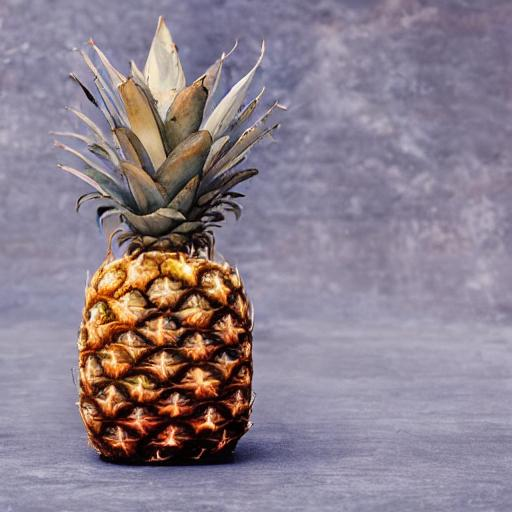
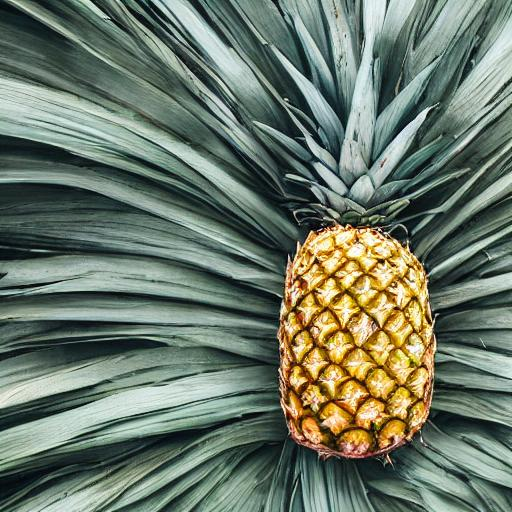
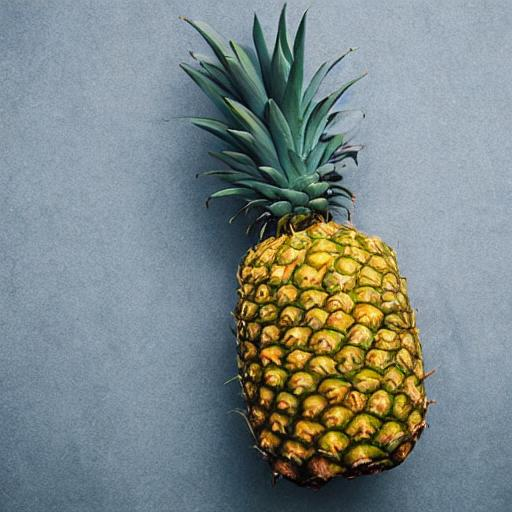
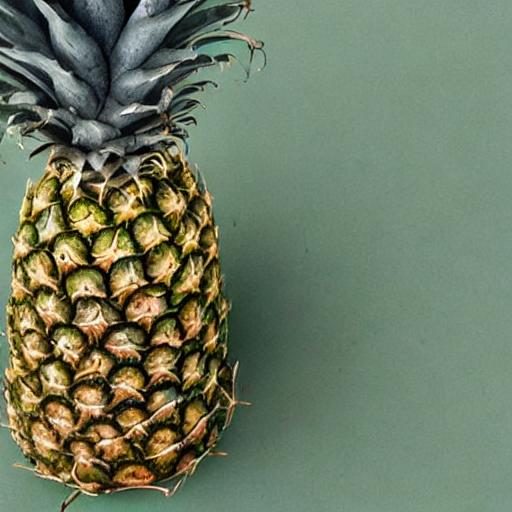
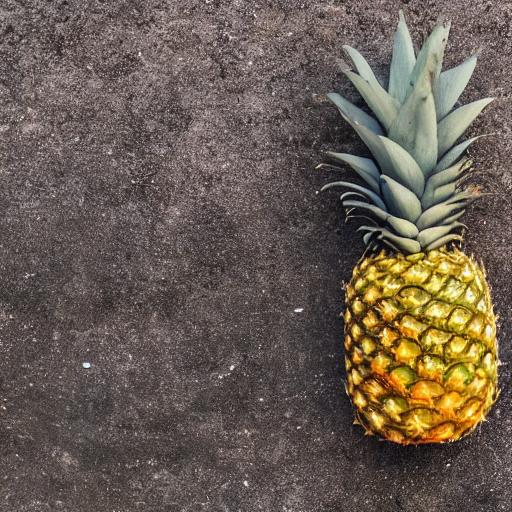

In [43]:
# Rank synthetic data by unrealistic-ness:
unrealistic_synthetic_samples_ranked = cleanset_df.query("real_or_synthetic == 'synthetic'").sort_values("label_issue_score", ascending=True)

# View least realistic synthetic samples:
columns = ["id", "image", "label", "label_issue_score"]
display(unrealistic_synthetic_samples_ranked[columns].head())

**Unrepresentative.**  The unrepresentative score evaluates whether the real data is well represented amongst the synthetic samples. High values of this score indicate that the synthetic generator fails to capture certain scenarios present in the real data (e.g. rare events). Mathematically, this score is computed as 1 minus the average Cleanlab **label issue score** over all real examples in a joint dataset with binary labels `real` or `synthetic`.

Let's see which real data scenarios failed to be represented amongst the synthetic data. To do so, sort the real data by their label issue scores (in ascending order). This produces a ranking of the real data in terms of how discernable each example is from all of the synthetic samples (Remember this counter-intuitive fact: *real* data points with the **lowest** label issue scores are those *most poorly represented* amongst the synthetic samples).

,id,image,label,label_issue_score
53,real_53,,pineapple,0.019082
121,real_121,,watermelon,0.023529
20,real_20,,pineapple,0.024523
57,real_57,,pineapple,0.025169
145,real_145,,watermelon,0.026541

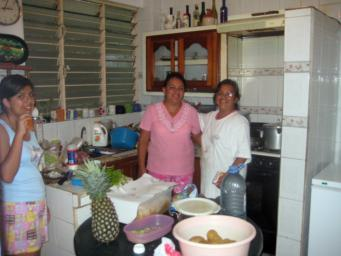
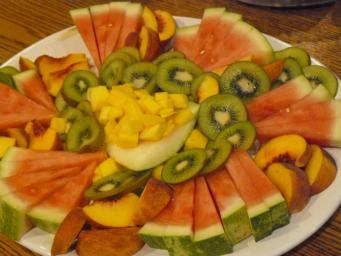
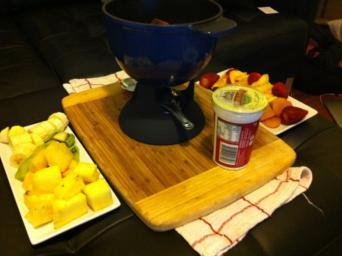
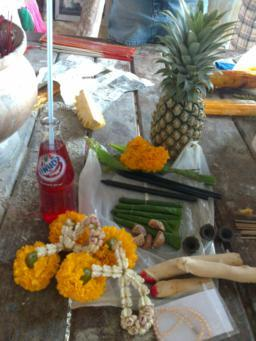
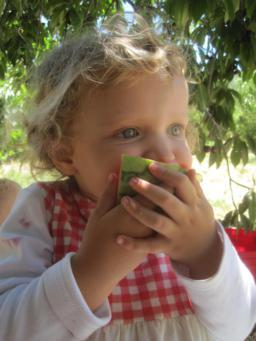

In [44]:
# Rank real data by unrepresentative-ness:
unrepresentative_real_samples_ranked = cleanset_df.query("real_or_synthetic == 'real'").sort_values("label_issue_score", ascending=True)

# View real data points from scenarios least well-represented within the synthetic dataset:
columns = ["id", "image", "label", "label_issue_score"]
display(unrepresentative_real_samples_ranked[columns].head())

**Unvaried.**  The unvaried and unoriginal scores measure the occurrence of near duplicates among synthetic samples. The **unvaried score** quantifies what proportion of synthetic samples are **near duplicates** of other *synthetic* samples (high values indicate a low-diversity synthetic dataset). The **unoriginal score** quantifies what proportion of synthetic samples are **near duplicates** of *real* data examples (high values indicate the synthetic data is mostly just memorized copies of the real data).

To see which examples are near duplicates of another example, group the data using the `near_duplicate_cluster_id`.
For visualizing the set of near-duplicated examples in our image dataset, we look up the associated image filenames and display some identifier (`id`) for each example in order to distinguish exact duplicates. The formatting of the `id` column in our dataset here also provides a sense of how many synthetic and real examples are in each duplicated group.

In [45]:
def filter_synthetic_examples_duplicated(df: pd.DataFrame, contains_real:bool):
    """Filters near duplicate examples by whether they belong to a near duplicate set that contains a real example or not."""
    filter_col = "real_or_synthetic"
    if contains_real:
        # Must contain both real and synthetic examples
        condition_fn = lambda group: (group[filter_col] == 'real').any() and (group[filter_col] == 'synthetic').any()
    else:
        # Must not contain any real examples
        condition_fn = lambda group: not (group[filter_col] == 'real').any()

    return df[df.is_near_duplicate].groupby('near_duplicate_cluster_id').filter(condition_fn)

First, we look at sets of near duplicates amongst only the synthetic data. 

These contribute to the "unvaried" score for the synthetic dataset, a high score suggests much of the synthetic data is being regurgitated over and over again (the synthetic dataset may be lacking in diversity). The dataframe below shows these synthetic near duplicates, along with the indices of each example (so you can see these are actually different examples from the dataset).

,id,image,label,real_or_synthetic,associated_images,near_duplicate_cluster_id
210,synthetic_10,,pineapple,synthetic,synthetic_97synthetic_105synthetic_132synthetic_137synthetic_146synthetic_149synthetic_150synthetic_168synthetic_173,5
268,synthetic_68,,pineapple,synthetic,synthetic_98,6
320,synthetic_120,,watermelon,synthetic,synthetic_199,7
338,synthetic_138,,watermelon,synthetic,synthetic_198,8
372,synthetic_172,,watermelon,synthetic,synthetic_200,9

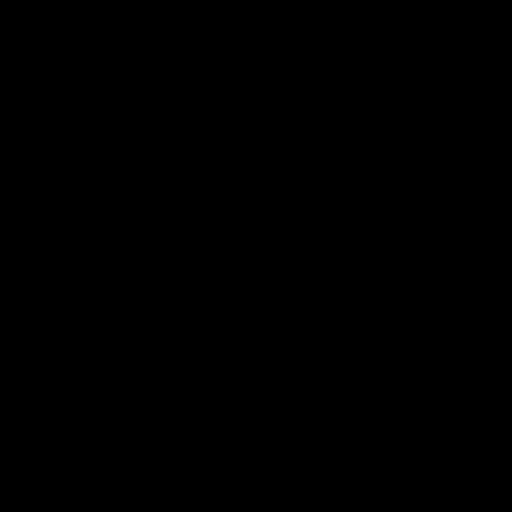
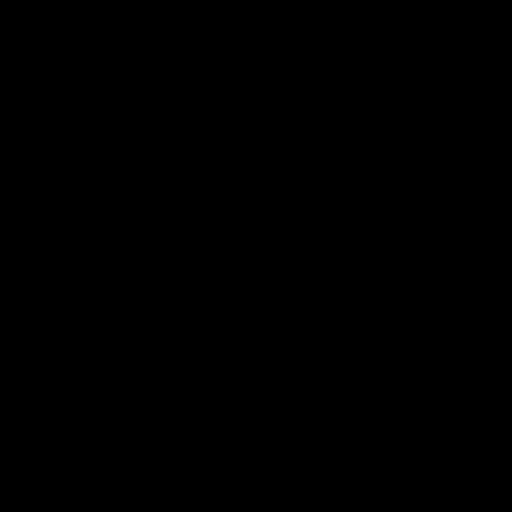
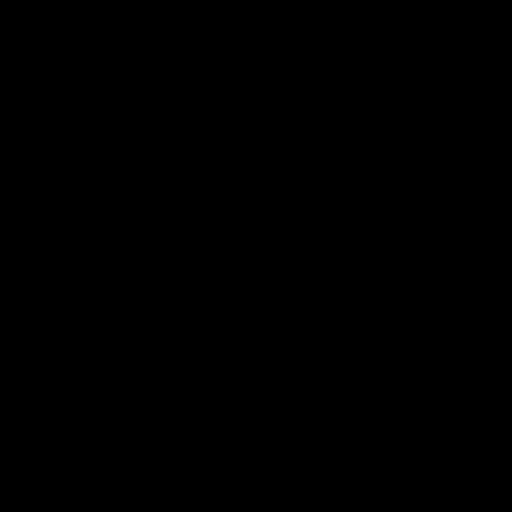
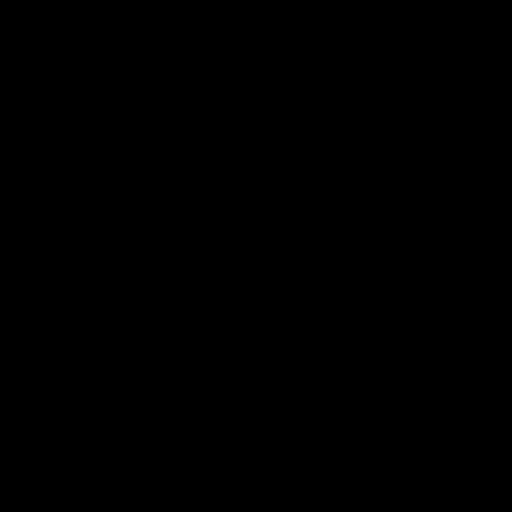
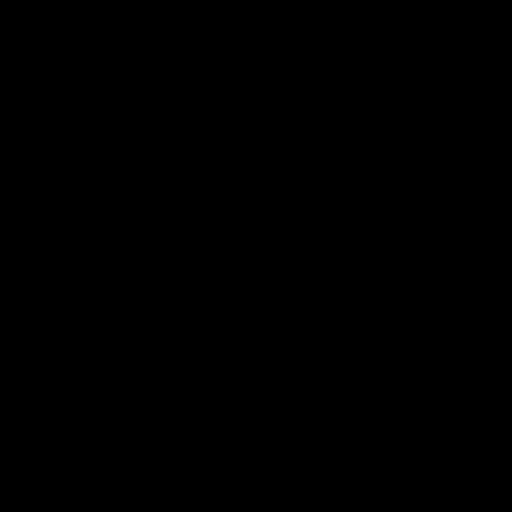
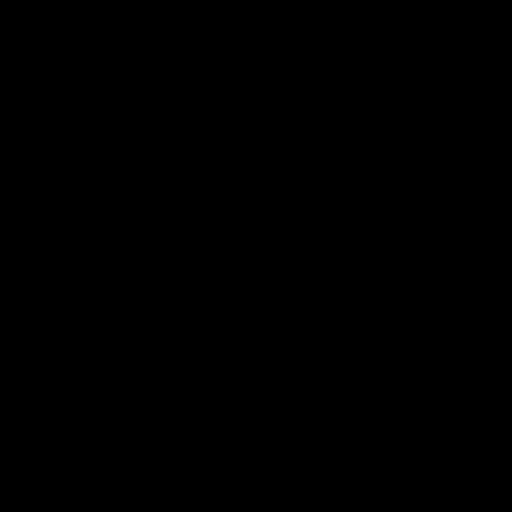
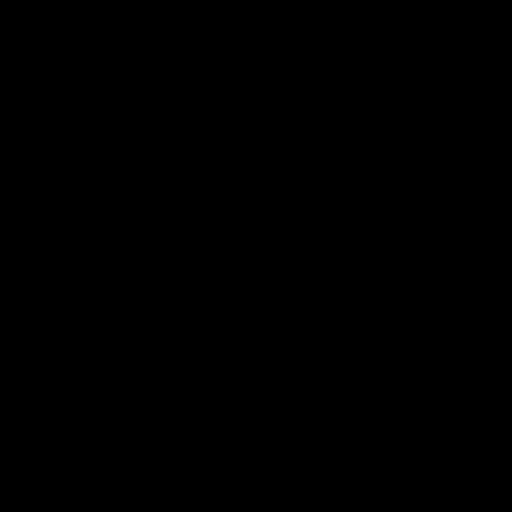
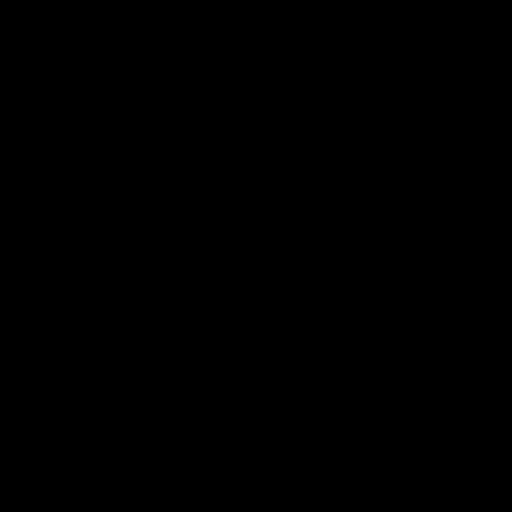
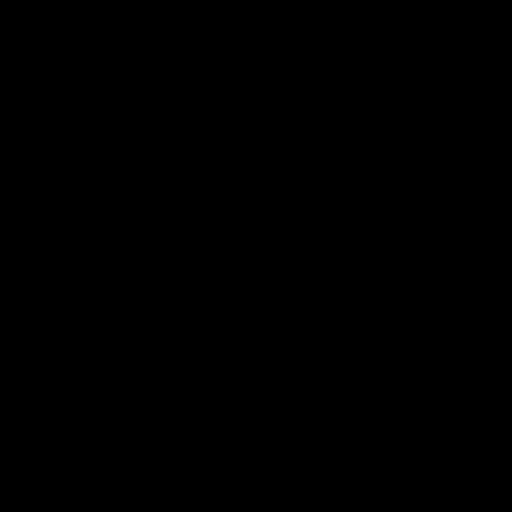
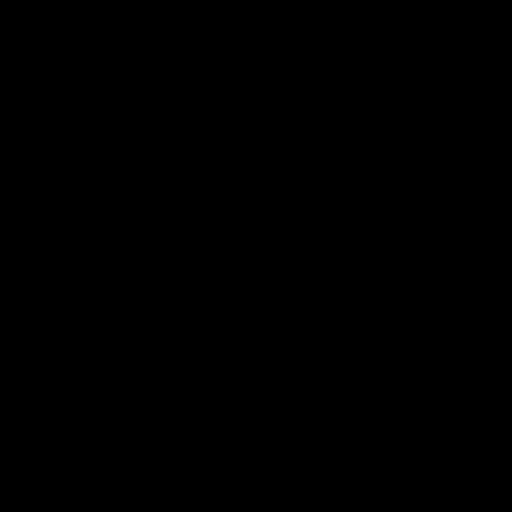
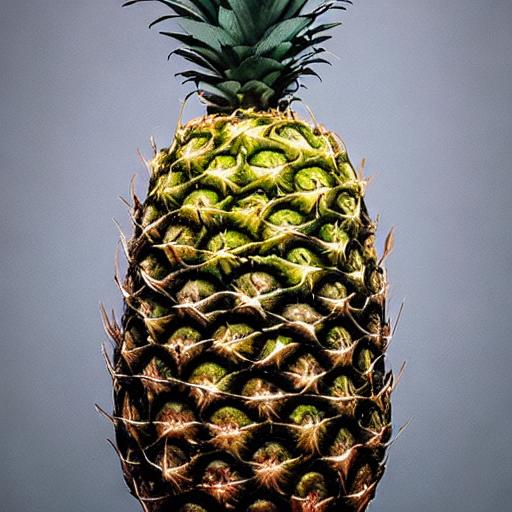
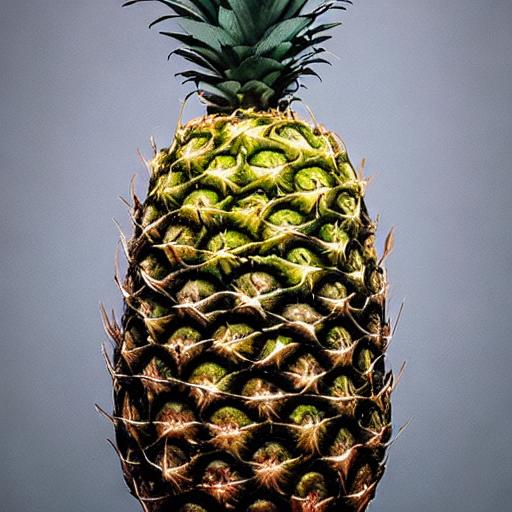
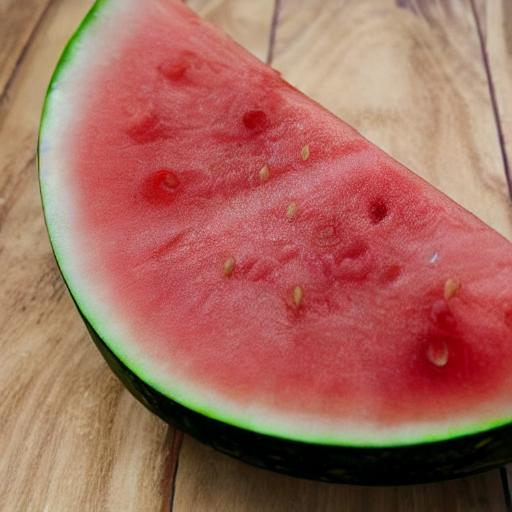
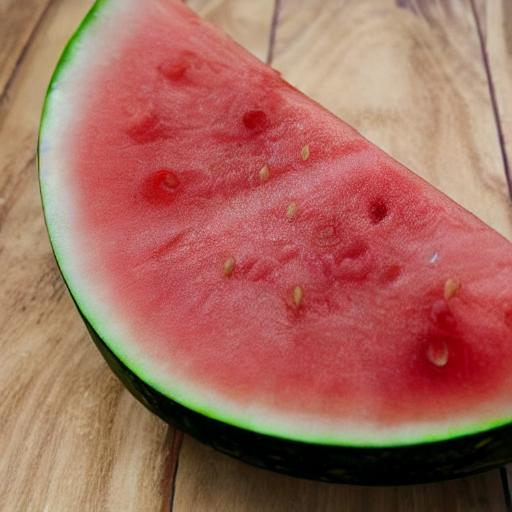
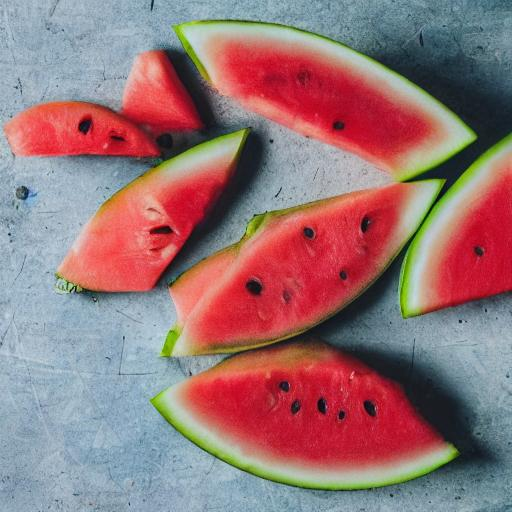
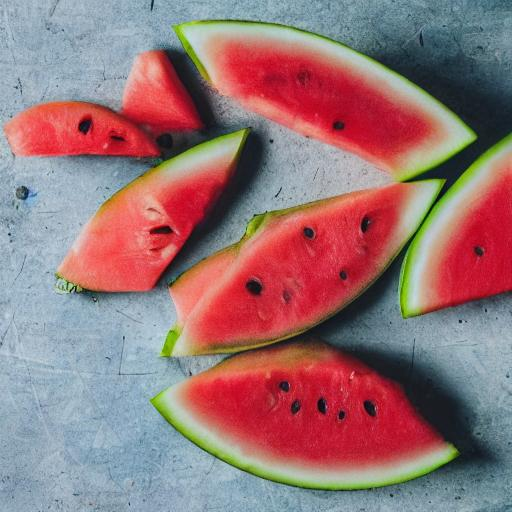
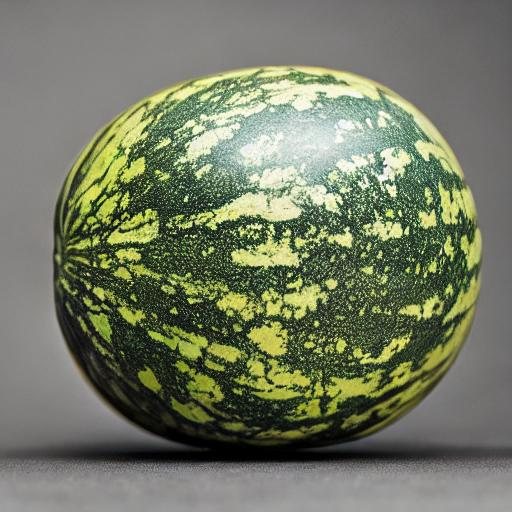
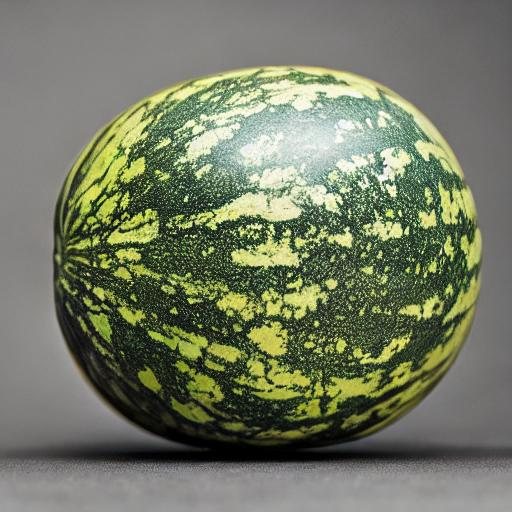

In [46]:
# Filter near duplicate examples that are not duplicated from real examples
unvaried_synthetic_samples = filter_synthetic_examples_duplicated(cleanset_df, contains_real=False)

# Display near duplicate examples with previously defined helper function
display_duplicated_examples(unvaried_synthetic_samples)

**Unoriginal.**  The other group of near duplicates worth inspecting are those synthetic examples that are near-identical copies of some real data example. These contribute to larger values of the **unoriginal score**, and are shown in the dataframe below with their near duplicates from the real data shown to their right. 

A high unoriginal score means that the synthetic data generator has likely memorized its training data and struggles to generate novel samples that are meaningfully different from the real data.

,id,image,label,real_or_synthetic,associated_images,near_duplicate_cluster_id
203,synthetic_3,,pineapple,synthetic,real_22,1
204,synthetic_4,,pineapple,synthetic,real_69,3
300,synthetic_100,,pineapple,synthetic,real_8,4
304,synthetic_104,,watermelon,synthetic,real_140,0
401,synthetic_201,,watermelon,synthetic,real_67,2

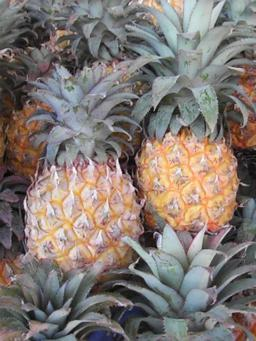
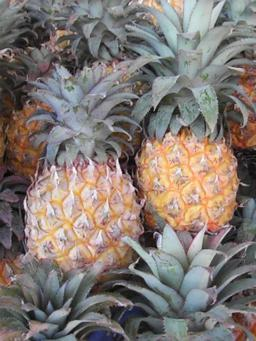
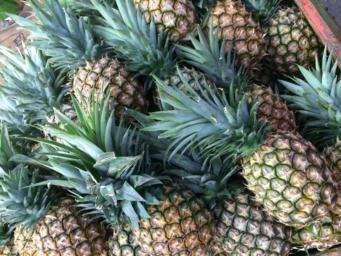
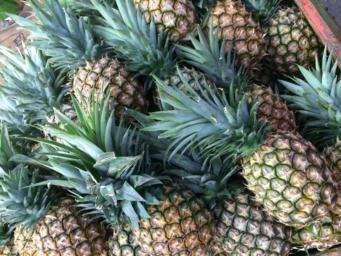
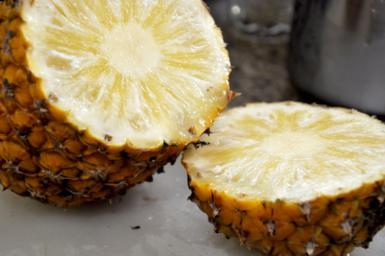
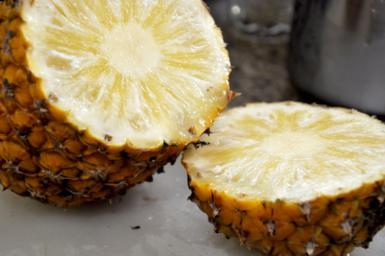
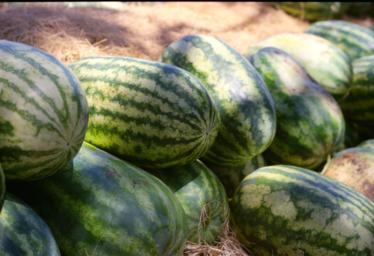
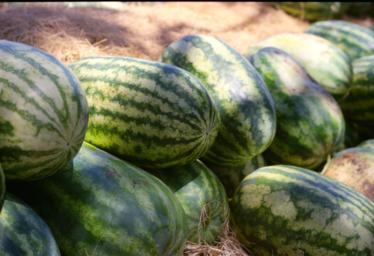
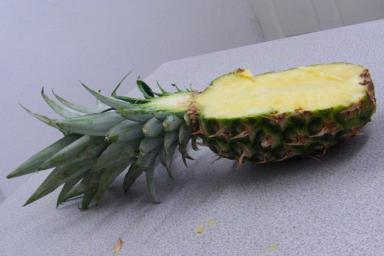
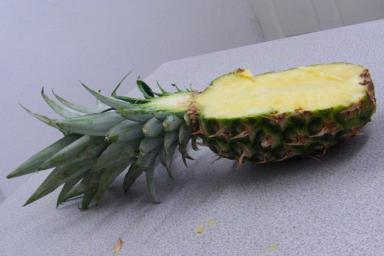

In [30]:
# Filter near duplicate examples that are duplicated from real examples
unoriginal_synthetic_samples = filter_synthetic_examples_duplicated(cleanset_df, contains_real=True)

# Display near duplicate examples
display_unoriginal_synthetic_examples(unoriginal_synthetic_samples)

## Next steps

The quality of your synthetic dataset is vital. We've shown you how to assess it with one particular image dataset, but the code from this tutorial can be generally applied to any synthetic and real data you might have (including **text** or **tabular** data). Our blog details some applications of this method to [text data](https://cleanlab.ai/blog/studio-synthetic-data/) or [image data](https://cleanlab.ai/blog/synthetic-image-with-stable-diffusion/).

Try repeatedly running this notebook and the `score_synthetic_dataset` function for every set of prompts (or other data generation settings you can tweak) to see if they improve the quality of your synthetic dataset. Note you can run many Cleanlab Studio projects simultaneously to speed up your synthetic dataset optimization and prompt engineering efforts.